<a id=top></a>
# Viewing STIS Data

## Learning Goals
By the end of this tutorial, you will go through: 
- [0.Introduction](#section0)
    - [0.1 Import necessary packages](#section0.1) 
- [1. Downloading STIS data from MAST using astroquery](#section1) 
- [2. Reading in the data](#section2)
    - [2.1 Investigating the data - Basics](#section2.1)
    - [2.2 Reading the table data](#section2.2)
- [3. Plotting the spectrum](#section3)
    - [3.1 Making a simple plot of the spectrum](#section3.1)
- [4. Working with data quality flags](#section4)
    - [4.1 Data quality frequencies histogram](#section4.1)
    - [4.2 Removing "Serious Data Quality"](#section4.2)
- [5. Visualizing STIS Image](#section5)
    - [5.1 Exploring image file structure](#section5.1)
    - [5.2 Showing the image](#section5.2)
    - [5.3 Removing serious data quality pixels](#section5.3)
- [6.Working with Time-Tag Data](#section6)
    - [6.1 Investigating the _tag Data](#section6.1)
    - [6.2 Converting Time_Tag into ACCUM image](#section6.2)
- [7.Working with STIS Echelle data](#section7)
    - [7.1 Showing Echelle Image](#section7.1)
    - [7.2 Plotting Echelle Spectrum](#section7.2)

<a id=section0></a>
## 0. Introduction

**The Space Telescope Imaging Spectrograph ([STIS](https://www.stsci.edu/hst/instrumentation/stis)) is a versatile imaging spectrograph installed on the Hubble Space Telescope ([HST](https://www.stsci.edu/hst/about)), covering a wide range of wavelengths from the near-infrared region into the ultraviolet.**

**This tutorial aims to prepare new users to begin analyzing STIS data by going through downloading data, reading and viewing spectra, and viewing STIS images.**

**There are three detectors on STIS: FUV-MAMA, NUV-MAMA, and CCD. While the detectors are designed for different scientific purposes and operate at a different wavelength, their data are organized in the same structure. Thus we are using FUV-MAMA data as an example in this notebook.**

For a detailed overview of the STIS instrument, see the [STIS Instrument Handbook](https://hst-docs.stsci.edu/stisihb). \
For more information on STIS data analysis and operations, see the [STIS Data Handbook](https://hst-docs.stsci.edu/stisdhb).

**Defining some terms:**

* **HST:** Hubble Space Telescope
* **STIS:** Space Telescope Imaging Spectrograph on HST (https://www.stsci.edu/hst/instrumentation/stis)
* **STIS/NUV-MAMA:** Cs2Te Multi-Anode Microchannel Array (MAMA) detector for observing mainly in the near ultraviolet (NUV)
* **STIS/FUV-MAMA:** Solar-blind CsI Multi-Anode Microchannel Array (MAMA) detector for observing mainly in the far ultraviolet (FUV)
* **CCD:** Charge Coupled Device 
* **FITS:** Flexible Image Transport System (https://fits.gsfc.nasa.gov/fits_primer.html)
* **HDU:** Header/Data Unit in a FITS file

<a id=section0.1></a>
### 0.1 Import necessary packages

**We will import the following packages:**

- `astropy.io.fits` for accessing FITS files
- `astropy.table.Table` for creating tidy tables of the data
- `astroquery.mast.Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `pathlib` for managing system paths
- `matplotlib.pyplot` for plotting data
- `IPython.display` for formatting display
- `numpy` to handle array functions
- `pandas` to make basic tables and dataframes
- `stistools` for operations on STIS data

In [ ]:
# Import for: Reading in fits file
from astropy.table import Table
from astropy.io import fits

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
from pathlib import Path

# Import for: Plotting and specifying plotting parameters
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from IPython.display import display

# Import for: Quick Calculation and Data Analysis
import numpy as np
import pandas as pd

# Import for operations on STIS Data
import stistools

<a id=section1></a>
## 1. Downloading STIS data from [MAST](https://archive.stsci.edu/) using [`astroquery`](https://astroquery.readthedocs.io/en/latest/)
There are other ways to download data from MAST such as using CyberDuck. We are only showing how to use astroquery in this notebook

In [ ]:
# make directory for downloading data
datadir = Path('./data')
datadir.mkdir(exist_ok=True)

In [ ]:
# Search target object by obs_id
target = Observations.query_criteria(obs_id='ODJ102010')
# get a list of files assiciated with that target
FUV_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
downloads = Observations.download_products(
    FUV_list,
    productType='SCIENCE',
    extension='fits',
    download_dir=str(datadir))
downloads

<a id=section2></a>
## 2. Reading in the data

<a id=section2.1></a>
### 2.1 Investigating the data - Basics
Before doing any operations on the data, we want to first explore the basics and data file structures.

The 1D-extracted, background subtracted, flux and wavelength calibrated spectra data are stored in a FITS file with suffix `_x1d` (note that for the CCD it is `_sx1`). While we are using the `_x1d` FITS file as an example of investigating STIS data, the following methods for reading in data and viewing a spectra or other fields can be applied to the other STIS data, either calibrated or uncalibrated. For more information on STIS file naming conventions, see [Types of STIS Files](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-2-types-of-stis-files) in the STIS Data Handbook.

Open the `x1d` fits file and explore its info and header:

In [ ]:
# get information about the fits file
x1d_file = Path('./data/mastDownload/HST/odj102010/odj102010_x1d.fits')
fits.info(x1d_file)

The primary header that stores keyword information describing the global properties of all of the exposures in the file 

In [ ]:
# get header of the fits file
x1d_header_0 = fits.getheader(x1d_file, ext=0)

for key in ["INSTRUME", "DETECTOR", "OBSMODE", "OPT_ELEM", "CENWAVE", "PROPAPER", "TARGNAME"]:
    print(f"{key}:\t{x1d_header_0[key]}")   

You can change the keys to check for other fields and metadata, or directly print the x1d_header_0 to get all header information.

Some other metadata, such as exposure data and time, are stored in the first extension.

In [ ]:
x1d_header_1 = fits.getheader(x1d_file, ext=1)

date = x1d_header_1["DATE-OBS"]
time = x1d_header_1["Time-OBS"]
exptime = x1d_header_1["EXPTIME"]

print(f"The data were taken on {date}, starting at {time}, with the exposure time of {exptime} seconds")

<a id=section2.2></a>
### 2.2 Reading table data
The main science data is stored in the first extension of the x1d FITS file. We first read in the data as an astropy Table.

In [ ]:
# Get data
x1d_data = Table.read(x1d_file, hdu=1)
# Display a representation of the data:
x1d_data

In [ ]:
# We can also get the columns of this table:
columns = x1d_data.colnames
columns

Another common way of reading in FITS data from an HDU list as "FITS_rec":

In [ ]:
with fits.open(x1d_file) as hdulist:
    fuv_x1d_data = hdulist[1].data
    
type(fuv_x1d_data)

<a id=section3></a>
## 3. Plotting the spectrum

<a id=section3.1></a>
### 3.1 Making a simple plot of the spectrum
The actual data of each column are stored in arrays within each row with equal lengths. We collect the spectrum data and plot them with corresponding error bars.

In [ ]:
# From the astropy table, we first get all the data we need: wavelength, flux, and error
# notice that for astropy table, the column name is case sensitive
# First-order data have data in only the 0th row, so we extract this sparse dimension.
wl, flux, err = x1d_data[0]['WAVELENGTH', 'FLUX', 'ERROR']

# Make a plot of the data, use this cell to specify the format of the plot.
matplotlib.rcParams['figure.figsize'] = [20, 7]
plt.style.use('bmh')

plt.plot(wl, flux,  # the x-data & y-data
         marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0) # specifies the data points style
plt.fill_between(wl, flux - err, flux + err, alpha=0.5)  # shade regions by width of error array
plt.title('STIS FUV Spectrum')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/s/cm$^2$/Å)')

You can zoom in to a specific wavelength range

In [ ]:
# plot the spectrum between 1540 and 1560 Å:
plt.plot(wl, flux,  # the x-data & y-data
         marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0,  # specifies the data point style
         color='blue')  # specifies the format of lines
plt.fill_between(wl, flux - err, flux + err, alpha=0.5)  # shade regions by width of error array
plt.title('STIS FUV Spectrum')
plt.xlabel('Wavelength (Å)')
plt.ylabel("Flux (ergs/s/cm$^2$/Å)")
plt.xlim(1540, 1560)

You can also plot the error bar together with the spectrum. For more errorbar styling options, see [`matplotlib.pyplot.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html)

In [ ]:
plt.errorbar(wl, flux, err,  # the x-data, y-data, and y-axis error
             marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0, color='blue',  # specifies the data points style
             ecolor='dodgerblue', capsize=0.1)  # specifies the format of lines and error bar
plt.title('STIS FUV Spectrum')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/s/cm$^2$/Å)')
plt.xlim(1540, 1560)

For more information on formatting the plots using matplotlib, see [`matplotlib.pyplot.plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html), [`matplotlib.pyplot.errorbar`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html).

<a id=section4></a>
## 4.Working with data quality flags

Data quality flags are assigned to each pixel in the data quality extension. Each flag has a true (set) or false (unset) state. Flagged conditions are set as specific bits in a 16-bit integer word. For a single pixel, this allows for up to 15 data quality conditions to be flagged simultaneously, using the bitwise logical OR operation. Note that the data quality flags cannot be interpreted simply as integers but may be converted to base-2 and interpreted as flags. These flags are set and used during the course of calibration, and may likewise be interpreted and used by downstream analysis applications.

<a id=section4.1></a>
### 4.1 Data quality frequencies histogram
Make a histogram according to the data quality flags, and label the bins by what each data quality values actually means.
More info: https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-5-error-and-data-quality-array

In [ ]:
# First get the possible data quality flag values to bitwise-and with the data quality flag:
dq_flags = ['Exclusively 0'] + list(1 << np.arange(0, 15))

dq_bits = {}
# In the Table representation, the data quality flag is a masked array that "hides" the pixels
# with no data quality issue. We fill those "good points" with 0 here when counting:
dq_bits[0] = np.count_nonzero(x1d_data[0]['DQ'].filled(0) == 0)  # exclusively 0

# Loop over non-zero flag values and count each:
for dq_flag in dq_flags[1:]:
    dq_bits[dq_flag] = np.count_nonzero((x1d_data[0]['DQ'] & dq_flag))

dq_bits

In [ ]:
# Assign the meaning of each data quality and make a histogram
meanings = {
    0:  "No Anomalies",
    1:  "Error in the Reed Solomon decoding",
    2:  "Lost data replaced by fill values",
    3:  "Bad detector pixel (e.g., bad column or row, mixed science and bias for overscan, or beyond aperture)",
    4:  "Data masked by occulting bar",
    5:  "Pixel having dark rate > 5 σ times the median dark level",
    6:  "Large blemish, depth > 40% of the normalized p-flat (repeller wire)",
    7:  "Vignetted pixel",
    8:  "Pixel in the overscan region",
    9:  "Saturated pixel, count rate at 90% of max possible—local non-linearity turns over and is multi-valued; "
        "pixels within 10% of turnover and all pixels within 4 pixels of that pixel are flagged.",
    10: "Bad pixel in reference file",
    11: "Small blemish, depth between 40% and 70% of the normalized flat. Applies to MAMA and CCD p-flats",
    12: ">30% of background pixels rejected by sigma-clip, or flagged, during 1-D spectral extraction",
    13: "Extracted flux affected by bad input data",
    14: "Data rejected in input pixel during image combination for cosmic ray rejection",
    15: "Extracted flux not CTI corrected because gross counts are ≤ 0"}

plt.bar(meanings.keys(), height=dq_bits.values(), tick_label=dq_flags)
plt.gca().set_xticklabels(dq_flags, rotation=-45, fontsize=15)
plt.yscale('log')
plt.ylim(0.5, 2000)
plt.show()

bits = [f'{0:015b}'] + [f'{1 << x:015b}' for x in range(0, 15)]

dq_table = pd.DataFrame({
    "Flag Value": dq_flags,
    "Bit Setting": bits,
    "Quality Condition Indicated": meanings.values()})
dq_table.set_index('Flag Value', drop=True, inplace=True)

pd.set_option('display.max_colwidth', None)
display(dq_table)

<a id=section4.2></a>
### 4.2 Removing "Serious Data Quality Flags"
Through the calibaration pipeline, some data qualities are marked "serious". The value of serious data qualities are marked through "SDQFLAGS". We can decompose that value according to the bits in order to see the specific data quality flags that are marked serious.

In [ ]:
sdqFlags_fuv = fits.getval(x1d_file, ext=1, keyword="SDQFLAGS")
print(f'The SDQFLAGS is {sdqFlags_fuv}, which is in binary {sdqFlags_fuv:015b},')
print('Therefore the following data qualities are marked "serious":')
for i in range(15):
    if 2**i & sdqFlags_fuv:
        print(f'\t{i+1:2.0f}: ' + meanings[i+1])

We can now remove the data points with SDQ flags. In the plots below, the first one is the same as the spectrum in which we do not handle the SDQ flags. The second one is the spectrum with SDQ flagged data removed, and the SDQ flagged data points are marked with red '+'.

In [ ]:
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(20, 10)
plt.style.use('bmh')

# First zoom in to the region where SDQ got removed
wl, flux, err, dq = x1d_data[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']

# Filter the datapoints to where there are no serious DQ flags
mask_noSDQ = (dq & sdqFlags_fuv) == 0

# get the spectrum without SDQ using the mask we just created
wvln_noSDQ, flux_noSDQ, err_noSDQ = wl[mask_noSDQ], flux[mask_noSDQ], err[mask_noSDQ]
# inverse the _noSDQ mask to collect the data points with SDQ flags
wvln_SDQ, flux_SDQ = wl[~mask_noSDQ], flux[~mask_noSDQ]  # apply the bitwise-not of mask

# plot1: the spectrum with SDQ flagged data included
# plt.subplot(2,1,1)
axes[0].plot(wl, flux,  # the x-data, y-data
             marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0)  # specifies the data points style

# plot2: plot the spectrum without SDQ flagged data, then mark the SDQ data points with +
# Plot the filtered datapoints
axes[1].plot(wvln_noSDQ, flux_noSDQ,  # the x-data, y-data
             marker='.', markersize=2, markerfacecolor='w', markeredgewidth=0, label="SDQ cleaned spectrum")
axes[1].plot(wvln_SDQ, flux_SDQ, 'r+', label='SDQ-flagged data')
axes[1].legend(loc='best')

# Format the figures:
axes[0].set_title('FUV with SDQ-flagged data')
axes[1].set_title('FUV without SDQ flagged data')
for ax in axes:
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux (ergs/s/cm$^2$/Å)')
    ax.set_xlim(wl.min() - 0.5, 1520)  # zoom in on left edge

<a id=section5></a>
## 5. Visualizing STIS Image

The STIS images are stored as two-dimensional arrays in FITS image extension files. For more information on STIS image files and extension, see [STIS FITS Image Extension Files](https://hst-docs.stsci.edu/stisdhb/chapter-2-stis-data-structure/2-3-stis-file-structures#id-2.3STISFileStructures-2.3.12.3.1STISFITSImageExtensionFiles)

<a id=section5.1></a>
### 5.1 Exploring image file structure
The rectified, wavelength and flux calibrated first order spectra or Geometrically corrected imaging data is stored in the fits file with the x2d extension (note that for the CCD the similar extension is sx2). Similar to what we did to the x1d file, we first open the fits file to explore its file structure.

In [ ]:
# read in the x2d file and get its info
x2d_file = Path('./data/mastDownload/HST/odj102010/odj102010_x2d.fits')
fits.info(x2d_file)

- The first, of extension type SCI, stores the science count/flux values.
- The second, of extension type ERR, contains the statistical errors, which are propagated through the calibration process. It is unpopulated in raw data files.
- The third, of extension type DQ, stores the data quality values, which flag suspect pixels in the corresponding SCI data. It is unpopulated in raw data files.

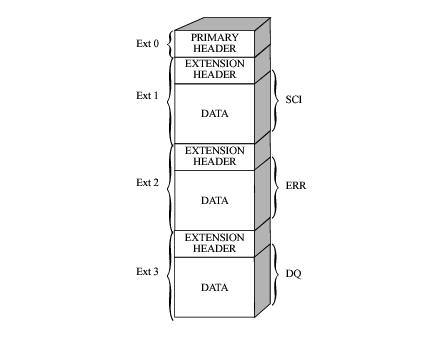

Similarly, we can also get the header from this FITS file to see the scientific metadata.

In [ ]:
# get header of the fits file
x2d_header = fits.getheader(x2d_file, ext=0)
x2d_header[:15]  # additional lines are not displayed here

<a id=section5.2></a>
### 5.2 Showing the image
Now we collect the science image data from the fits file and show the image.

In [ ]:
# get data as a numpy array
with fits.open(x2d_file) as hdu_list:
    x2d_data = hdu_list[1].data

Make a histogram of the magnitude of the image data so that we have a general idea on the distribution. Knowing the distribution is essential for us to normalize the data when showing the image.

In [ ]:
# remove infinities and NaNs from the data when making the histogram
filtered_data = [v for row in np.log10(x2d_data) for v in row if not (np.isinf(v) or np.isnan(v))]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 5)

ax.hist(filtered_data, range=[-20.5, -8.5], bins=12)
ax.set_xlabel('Magnitude order of _x2d image data')
ax.set_ylabel('count')
ax.set_title('_x2d Data Magnitude Order frequencies')

When showing the image, we normalize the color of each pixel to a specific range through vmin and vmax to make the features of image clear. These values typically matches the magnitude of the `x2d` data according to the histogram above, but can be experimented and changed to bring out features at different levels.

In [ ]:
# show the image
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.imshow(x2d_data, origin='lower', vmin=0, vmax=1e-13, cmap="viridis")

For more color map and normalizing options, see: [`Choosing Colormaps in Matplotlib`](https://matplotlib.org/stable/tutorials/colors/colormaps.html), [`matplotlib.pyplot.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html).

<a id=section5.3></a>
### 5.3 Removing serious data quality pixels
Now we are going to remove the pixels with series data quality flags as described above. The removed pixels will appear grey like the background. The horizontal stripes of removed data are from the bar (top) and repeller wire shadow (middle).

In [ ]:
# get the serious data quality flag
sdqFlags_fuv = fits.getheader(x2d_file, 1)["SDQFLAGS"]
# get data quality flags of each pixels
with fits.open(x2d_file) as hdu_list:
    x2d_dq = hdu_list[3].data
    
    
# create a mask of bad pixels and set them to nan
def check_dq(dq):
    return bool(dq & sdqFlags_fuv)


mask = np.vectorize(check_dq)(x2d_dq)
x2d_mask = np.ma.array(x2d_data, mask=mask, fill_value=np.nan)
# plot the image
plt.imshow(x2d_mask, origin='lower', vmin=0, vmax=1e-13, cmap="viridis")

<a id=section6></a>
## 6.Working with Time-Tag data

The MAMA detecters have a unique Time-Tag mode besides ACCUM mode. TIME-TAG mode is used for high-time-resolution spectroscopy and imaging in the UV. In TIME-TAG mode, the position and detection time of every photon is recorded in an event list. The Time-Tag mode operation for the MAMA detectors can be found at: [MAMA TIME-TAG Mode](https://hst-docs.stsci.edu/stisihb/chapter-11-data-taking/11-1-basic-operating-modes#id-11.1BasicOperatingModes-Section11.1.311.1.3MAMATIME-TAGMode).

In TIME-TAG mode, the position and detection time of every photon is recorded in an event list.
First download the _tag data:

In [ ]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id='odgxt9010')
# get a list of files assiciated with that target
NUV_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
Observations.download_products(NUV_list, extension='fits', download_dir=str(datadir))

<a id=section6.1></a>
### 6.1 Investigating the _tag data

In [ ]:
# get info about the tag extension fits file
tag = Path("./data/mastDownload/HST/odgxt9010/odgxt9010_tag.fits")
fits.info(tag)

The _tag fits file has two binary table extensions: EVENTS and GTI (Good Time Interval).

In [ ]:
# get header of the EVENTS extension
# print only the TIMETAG EVENTS TABLE COLUMNS (line 130-147)
fits.getheader(tag, 1)[130:147]

Columns in the EVENTS extension:
- TIME: the time each event was recorded relative to the start time
- AXIS1: pixel coordinate along the spectral axis with the corretion term on Doppler shifts
- AXIS2: pixel coordinate along the spatial axis
- DETAXIS1: pixel coordinate along the spectral axis without the corretion term on Doppler shifts

In [ ]:
# get header of the GTI extension
fits.getheader(tag, 2)

In [ ]:
Table.read(tag, 2)

Columns in the GTI extension:
- START: start of good time interval
- STOP: end of good time interval

Now we make a time series plot of the total flux over all wavelengths to see how the flux changes over the time interval:

In [ ]:
# read the events data as a pandas dataframe for easier manipulation
events = Table.read(tag, 1).to_pandas()
# get the good time interval from the GTI extension
start, stop = Table.read(tag, 2)["START"], Table.read(tag, 2)["STOP"]
# group the events by time with bin = 3 seconds
time = np.arange(int(start), int(stop), 3)
ind = np.digitize(events['TIME'], time)
total_flux = events.groupby(ind).count()["TIME"]
# plot the flux as a function of time
# notice here that the unit of flux is counts since we are counting the number of events in a time series
matplotlib.rcParams['figure.figsize'] = (20, 7)
plt.plot(time, total_flux, marker=".", mfc="w")
plt.xlabel("Time [s]")
plt.ylabel("Total Flux [counts]")

As the plot shows, though the total flux fluctuates, it is roughly a constant over the good time interval.

<a id=section6.2></a>
### 6.2 Converting Time_Tag into ACCUM image
Time tag data can be converted into ACCUM image using the inttag method in stistools.
More information: [inttag](https://stistools.readthedocs.io/en/latest/inttag.html)

In [ ]:
# define the output file
accum = "./data/mastDownload/HST/odgxt9010/odgxt9010_accum.fits"
# convert Time_Tag into ACCUM
# the first parameter is the path to the _tag fits file, the second parameter is the output directory
stistools.inttag.inttag(tag, accum)

Then the output file is in the same structure as a STIS image fits file, which we can open and plot in the same way we explored above:

In [ ]:
with fits.open(accum) as hdul:
    im = hdul[1].data
plt.imshow(im, origin='lower', vmin=0, vmax=6, cmap="viridis")

inttag can be run to produce multiple output imsets: rcount specifies the number of imsets, imcrements specifies the time interval for each imsets in seconds

In [ ]:
stistools.inttag.inttag(tag, accum, rcount=3, increment=700)
fits.info(accum)

Compare the 3 accum images produced by inttag, using the same scale and colormap:

In [ ]:
for i in range(1, 8, 3):
    with fits.open(accum) as hdul:
        im = hdul[i].data
    plt.subplot(1, 3, int(i/3)+1)
    plt.imshow(im, origin='lower', vmin=0, vmax=2, cmap="viridis")
    plt.title("extension {}".format(i))
plt.tight_layout()

The output file is a series of extensions with each imset having a SCI, ERR, and DQ extension, as shown above.

<a id=section7></a>
## 7.Working with STIS Echelle data

The STIS Echelle mode uses diffraction and interference to separate a spectrum into different spectral orders (the keyword in the headers is SPORDER), with each spectral order covering different wavelength range. The echelle were designed to maximize the spectral range covered in a single echellogram. For more information, see [Echelle Spectroscopy in the Ultraviolet](https://hst-docs.stsci.edu/stisihb/chapter-4-spectroscopy/4-3-echelle-spectroscopy-in-the-ultraviolet).

We first download data taken with an echelle:

In [ ]:
# Search target objscy by obs_id
target = Observations.query_criteria(obs_id='OCTX01030')
# get a list of files assiciated with that target
NUV_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
Observations.download_products(NUV_list, productType="SCIENCE", extension='fits', download_dir=str(datadir))

<a id=section7.1></a>
### 7.1 Showing Echelle Image

Open the _flt (Flat-fielded science) image in the same way we open other image files, and show the image:

In [ ]:
flt_file = "./data/mastDownload/HST/octx01030/octx01030_flt.fits"
with fits.open(flt_file) as hdu:
    image = hdu[1].data
    plt.imshow(image, origin='lower', vmin=0, vmax=1, cmap="viridis")

As shown in the image above, there are multiple horizontal bands with different spectral orders. Each spectral order also has distinct wavelength range, which we will explore in the next section.

<a id=section7.2></a>
### 7.2 Plotting Echelle Spectrum

We first read in the _x1d data as an astropy table. Notice that when we read in the FUV _x1d data in [section2.2](#section2.2), the table has a single row with SPORDER = 1. But for echelle mode data, the data is separated into multiple rows, with each row having a distinct order.

In [ ]:
echelle_file = "./data/mastDownload/HST/octx01030/octx01030_x1d.fits"
echelle_data = Table.read(echelle_file, 1)
echelle_data

Now we can plot the spectrum of all spectral orders in one plot, with each spectral order having a distinct color:

In [ ]:
# plot the spectrum; the color of each SPORDER is specified through a matplotlib built-in colormap
matplotlib.rcParams['figure.figsize'] = (20, 7)

for i in range(len(echelle_data)):
    plt.plot(echelle_data[i]['WAVELENGTH'], echelle_data[i]['FLUX'], color=cm.get_cmap('prism')(i/len(echelle_data)), label=echelle_data[i]['SPORDER'], alpha=0.7)
plt.xlabel('Wavelength [' + chr(197) + ']')
plt.ylabel("Flux [ergs/s/cm$^2$/" + chr(197) + "]")
plt.legend(loc='best')
plt.title("STIS Echelle Mode Spectrum")

As the spectrum illustrates, each spectral order covers a specific wavelength range. Notice that some of the wavelength ranges overlap.


---
## About this Notebook
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2023-01-05


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
